# Introduction

This Data Science project focuses on classifying images of Formula 1 drivers. The dataset, curated through web scraping, provides a diverse collection of driver images to train and evaluate our classification model. The goal is to accurately identify and categorize these drivers based on their visual features.

In [4]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import json
import zipfile

In [5]:
#avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

# Data Preprocessing

In [6]:
#import dataset
data_dir = path = r"model\Formula1_Drivers_Image_Dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

#check every file in specific folder
os.listdir(data_dir)

['alex_albon',
 'charles_leclerc',
 'lewis_hamilton',
 'max_verstappen',
 'zhou_guanyu']

In [34]:
#store supported images only
filtered_data_dir = r"model\Filtered_Formula1_Drivers_Image_Dataset"

#clean up unsupported images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [8]:
#load and preprocess dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='int',
    image_size=(256, 256),
    batch_size=32
)

Found 197 files belonging to 5 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

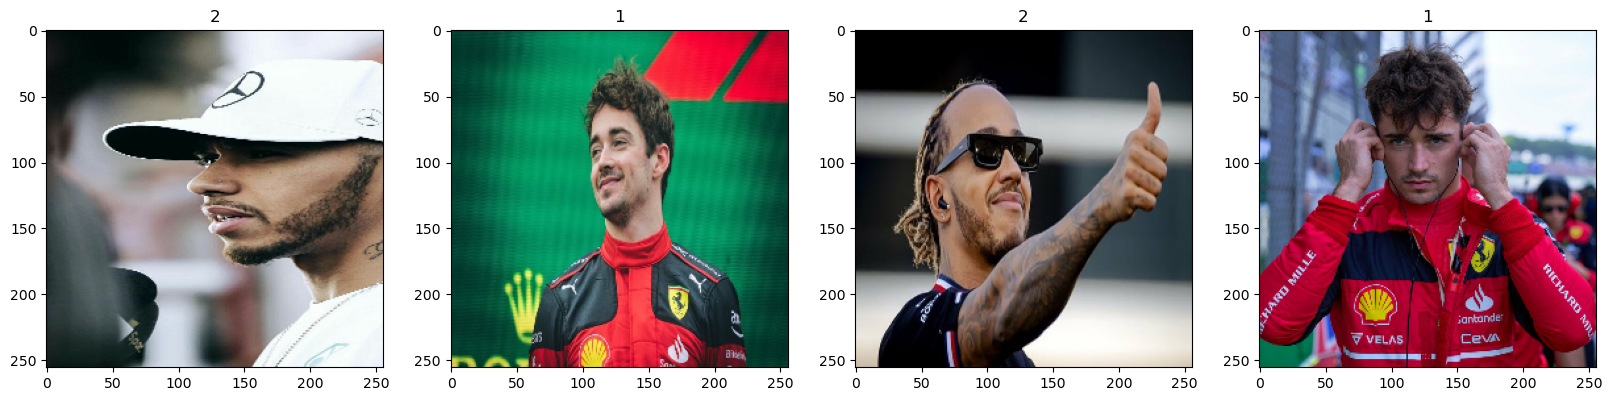

In [10]:
#show first 4 images
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

In [11]:
#normalise images to a range of 0 to 1
data = data.map(lambda x, y: (x / 255.0, y))

In [12]:
#images as numpy array
batch[0].shape

#0 = alex
#1 = charles
#2 = lewis
#3 = max
#4 = zhou

batch[1]

array([2, 1, 2, 1, 0, 1, 0, 0, 3, 4, 2, 2, 0, 0, 2, 0, 0, 3, 3, 0, 3, 0,
       1, 4, 4, 2, 0, 1, 0, 3, 4, 3])

In [13]:
num_batches = tf.data.experimental.cardinality(data).numpy()

#split into train, test and validation
train_size = int(num_batches * 0.7)
val_size = int(num_batches * 0.2)
test_size = num_batches - train_size - val_size

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Model Building

In [15]:
model = Sequential()

In [16]:
#CNN model
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax')) 

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,965 (32.09 MB)

 Trainable params: 8,412,965 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [19]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.2396 - loss: 1.6619 - val_accuracy: 0.3750 - val_loss: 1.4966
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3969 - loss: 1.4637 - val_accuracy: 0.3750 - val_loss: 1.4498
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4281 - loss: 1.3714 - val_accuracy: 0.4688 - val_loss: 1.2783
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4083 - loss: 1.3637 - val_accuracy: 0.6875 - val_loss: 1.1500
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5969 - loss: 1.2623 - val_accuracy: 0.5000 - val_loss: 1.2353
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5167 - loss: 1.2045 - val_accuracy: 0.3438 - val_loss: 1.2886
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5833 - loss: 1.1552 - val_accuracy: 0.6875 - val_loss: 1.0437
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6604 - loss: 1.0810 - val_accuracy: 0.7500 - val_loss: 0.8218
Epoch 9/20
4/4 

# Performance Analysis

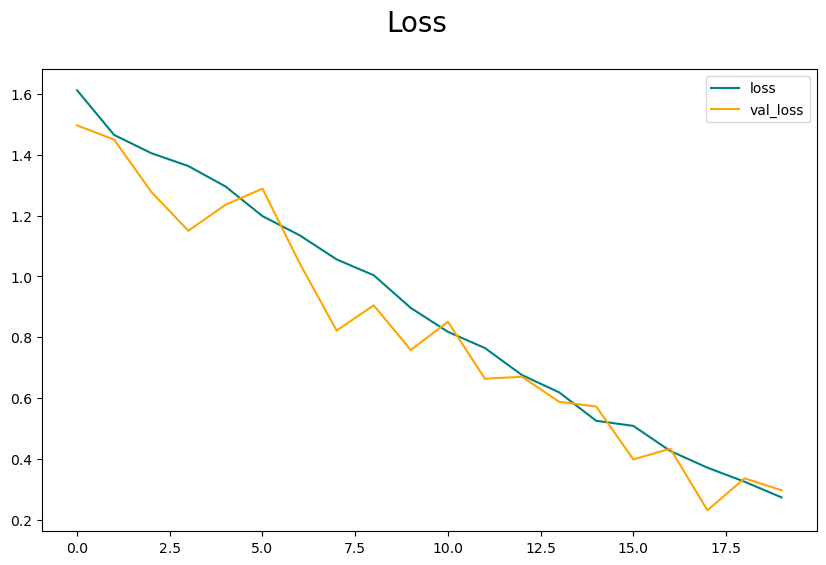

In [21]:
#plot loss
fig = plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

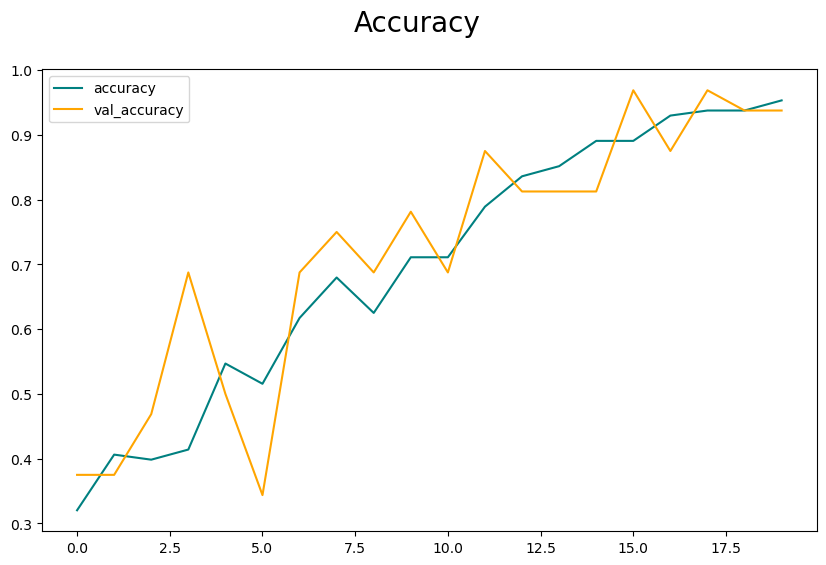

In [22]:
#plot accuracy
fig = plt.figure(figsize=(10, 6))
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [23]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [24]:
#evaluation of chosen metrics
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


In [25]:
#conversion to indices
yhat_classes = tf.argmax(yhat, axis=-1)

In [26]:
#post indice conversion metrics
acc.update_state(y, yhat_classes)
pre.update_state(y, yhat_classes) 
re.update_state(y, yhat_classes)

In [27]:
print("Categorical Accuracy:", acc.result().numpy())
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())

Categorical Accuracy: 1.0
Precision: 1.0
Recall: 1.0


# Model Testing

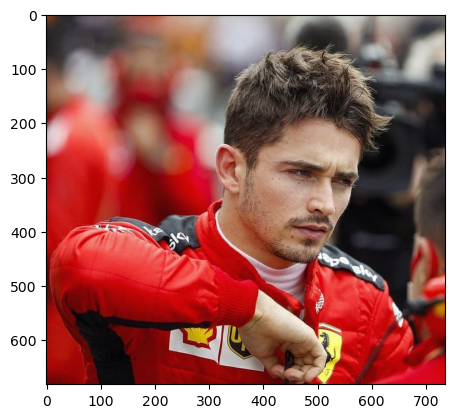

In [29]:
#load test image
img = cv2.imread(r'model\Formula1_Drivers_Image_Dataset\test_charles.png')
#BGR to RBG colour conversion
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
plt.imshow(img_rgb)
plt.show()

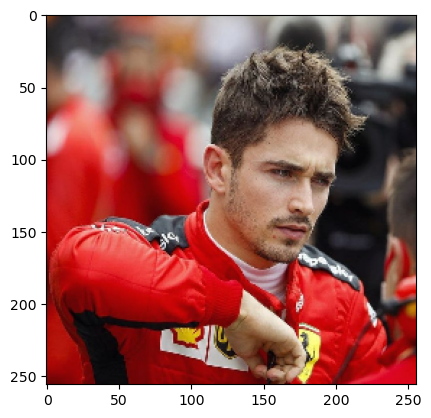

In [30]:
#reize test image
resize = tf.image.resize(img_rgb, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
#class prediction
yhat = model.predict(np.expand_dims(resize / 255.0, 0))

predicted_class = tf.argmax(yhat, axis=-1).numpy()[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [32]:
#lable the classes
class_labels = ['Alex Albon', 'Charles Leclerc', 'Lewis Hamilton', 'Max Verstappen', 'Zhou Guanyu']

In [33]:
print(f'Predicted Diver: {class_labels[predicted_class]}')

Predicted Diver: Charles Leclerc


# Save Model

In [ ]:
#save dictionary
class_names = os.listdir(data_dir)
class_dict = {}
count = 0
for class_name in class_names:
    class_dict[class_name] = count
    count += 1

print('Class dictionary:', class_dict)

with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

Class dictionary: {'zhou_guanyu': 0, 'lewis_hamilton': 1, 'alex_albon': 2, 'charles_leclerc': 3, 'max_verstappen': 4}


In [ ]:
#save model
model.save('saved_model.keras')

loaded_model = tf.keras.models.load_model('saved_model.keras')

In [ ]:
#create output zipfile to export

# Define the zip file path
zip_filename = '/kaggle/working/outputs.zip'

# Create a ZipFile object
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add the logs directory (all files inside)
    for root, dirs, files in os.walk('/kaggle/working/logs'):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, '/kaggle/working'))
    
    # Add class_dictionary.json
    zipf.write('/kaggle/working/class_dictionary.json', 
               'class_dictionary.json')
    
    # Add saved_model.keras
    zipf.write('/kaggle/working/saved_model.keras', 
               'saved_model.keras')

print("Created outputs.zip")

Created outputs.zip
